In [25]:
import numpy as np
from astropy.io import fits

tempimagename = fits.open(f"/users/kushpatel/downloads/final_g_image.fits")
temp_data = tempimagename[0].data
tempimagename1 = fits.open(f"/users/kushpatel/downloads/final_Ha_image.fits")
temp_data1 = tempimagename1[0].data

print(np.max(temp_data))
print(np.max(temp_data1))

2427897.0524625555
466395.28823597485


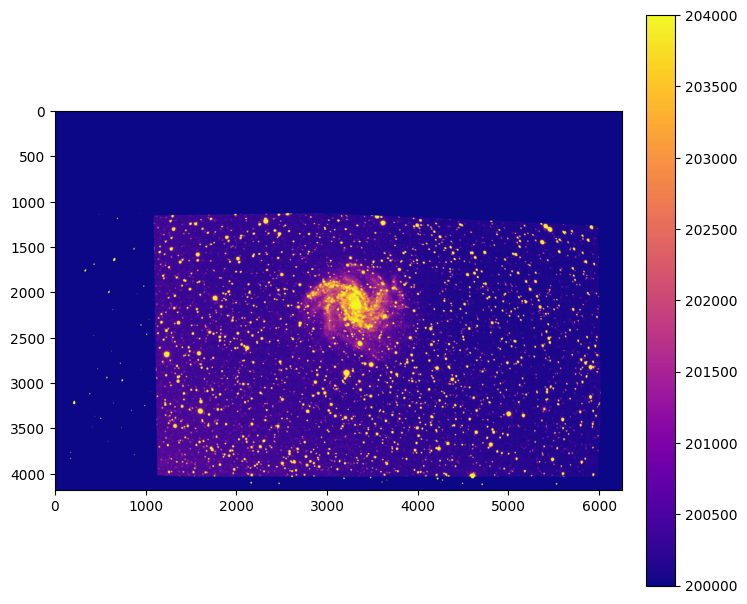

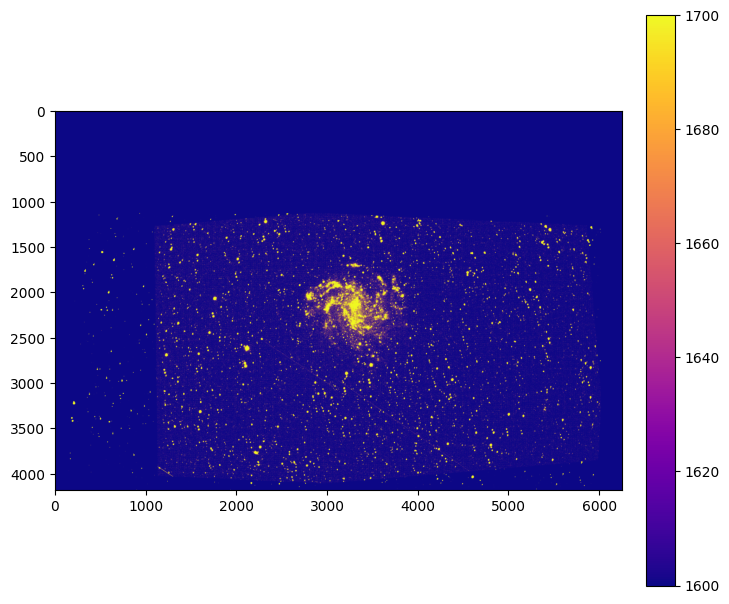

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
fig = plt.imshow(temp_data,vmin=200000,vmax=204000,cmap='plasma')
plt.colorbar(fig,fraction=0.046,pad=0.04)

plt.figure(figsize=[8,8])
fig = plt.imshow(temp_data1,vmin=1600,vmax=1700,cmap='plasma')
plt.colorbar(fig,fraction=0.046,pad=0.04)


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

def manual_ellipse_picker(image, col0, row0, rad1_0, rad2_0,
                          vmin=None, vmax=None):

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(image, vmin=vmin, vmax=vmax, cmap='plasma')
    plt.colorbar(im, fraction=0.046, pad=0.04)

    ax.set_title("Adjust Ellipse for Initial Guess")

    p = np.linspace(0, 2*np.pi, 400)

    # Initial ellipse
    xc = col0 + rad1_0*np.cos(p)
    yc = row0 + rad2_0*np.sin(p)
    ellipse_line, = ax.plot(xc, yc, 'w', lw=2)

    def update(val):
        rad1 = s_a.val
        rad2 = s_b.val
        xc = col0 + rad1*np.cos(p)
        yc = row0 + rad2*np.sin(p)
        ellipse_line.set_data(xc, yc)
        fig.canvas.draw_idle()

    plt.show()

    print("After closing the window, use these initial values:")
    print(f"col = {col0}")
    print(f"row = {row0}")
    print(f"rad1 = {rad1_0:.1f}")
    print(f"rad2 = {rad2_0:.1f}")

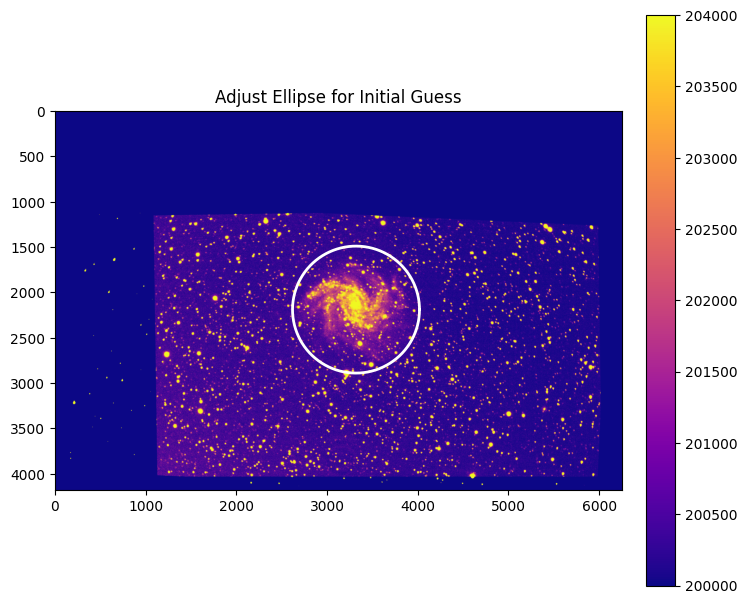

After closing the window, use these initial values:
col = 3320
row = 2190
rad1 = 700.0
rad2 = 700.0


In [48]:
# Circular Aperture Approximately Encloses and matches the shape of the source
# As both g' and Ha images are aligned with same calibration star, 
# we use similar col0 and row0 for both

manual_ellipse_picker(
    temp_data,
    col0=3320,      # your estimated source X
    row0=2190,      # your estimated source Y
    rad1_0=700,
    rad2_0=700,
    vmin=200000,
    vmax=204000
)

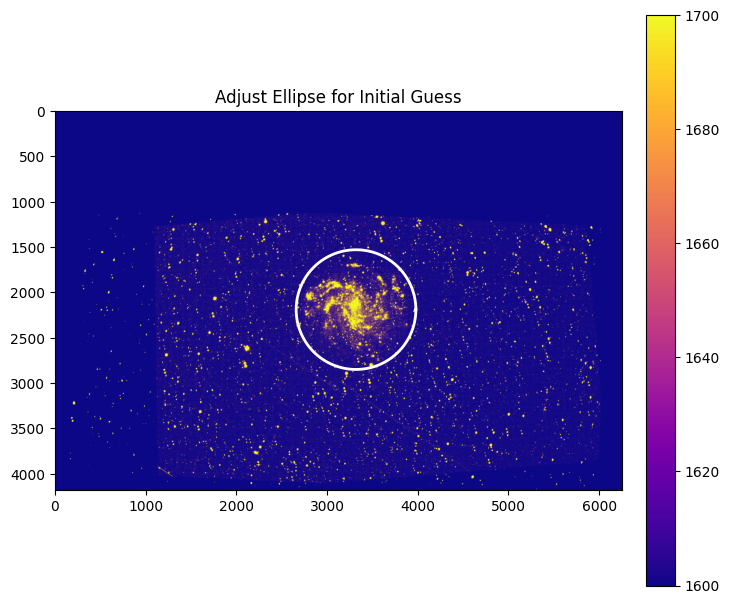

After closing the window, use these initial values:
col = 3320
row = 2190
rad1 = 660.0
rad2 = 660.0


In [49]:
# Circular Aperture Approximately Encloses and matches the shape of the source

manual_ellipse_picker(
    temp_data1,
    col0=3320,      # your estimated source X
    row0=2190,      # your estimated source Y
    rad1_0=660,
    rad2_0=660,
    vmin=1600,
    vmax=1700
)

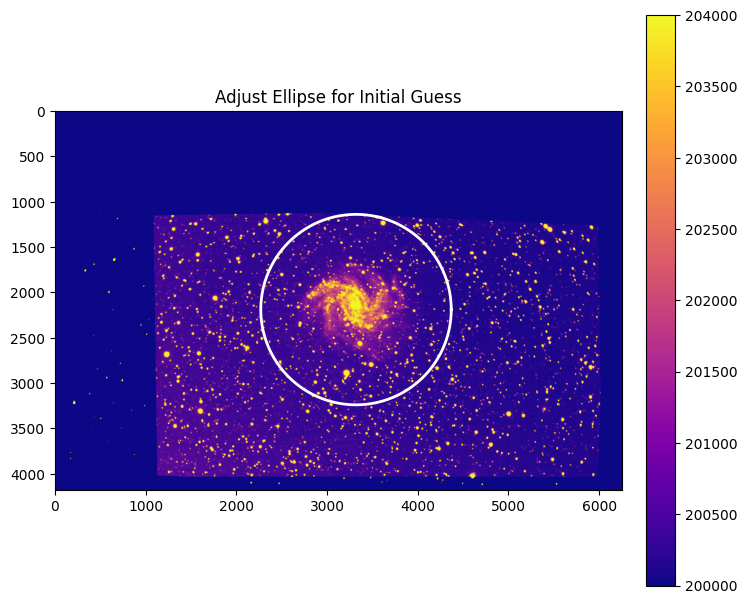

After closing the window, use these initial values:
col = 3320
row = 2190
rad1 = 1050.0
rad2 = 1050.0


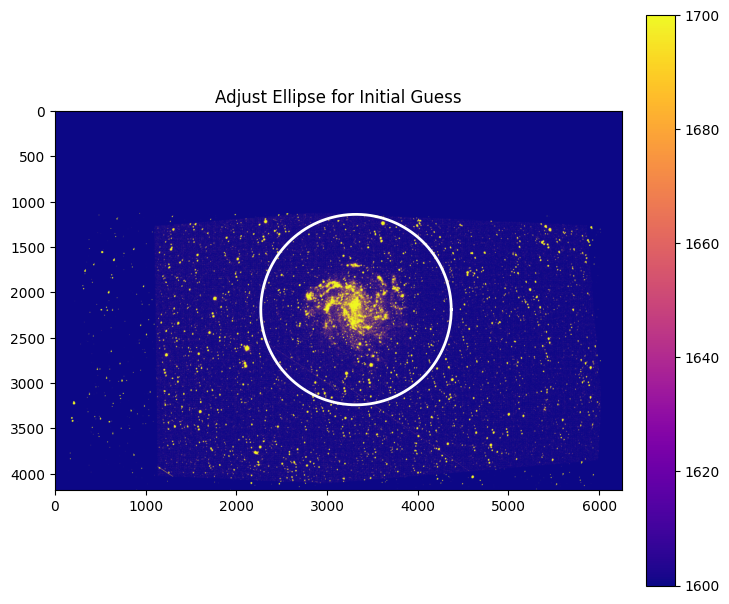

After closing the window, use these initial values:
col = 3320
row = 2190
rad1 = 1050.0
rad2 = 1050.0


In [50]:
# 1050 appears to border the edge of the fully stacked background in both images
# So we use 1040 as the max for the outer radius of the sky annulus for both images

manual_ellipse_picker(
    temp_data,
    col0=3320,      
    row0=2190,      
    rad1_0=1050,
    rad2_0=1050,
    vmin=200000,
    vmax=204000
)

manual_ellipse_picker(
    temp_data1,
    col0=3320,
    row0=2190,
    rad1_0=1050,
    rad2_0=1050,
    vmin=1600,
    vmax=1700
)

In [81]:
def aperE_graphless(im, col, row, rad1, rad2, ir1, ir2, or1, or2, Kccd, saturation=np.inf):
# Aperture Photometry
    a, b = im.shape

    xx, yy = np.meshgrid(range(b), range(a))

    ixsrc = ((xx - col) / rad1) ** 2 + ((yy - row) / rad2) ** 2 <= 1  # returns a boolean array same size as the image where True is part of the target aperture

    ixsky = np.logical_and(
        (((xx - col) / or1) ** 2) + (((yy - row) / or2) ** 2) <= 1,
        (((xx - col) / ir1) ** 2) + (((yy - row) / ir2) ** 2) >= 1,
    )  # returns a boolean array same size as the image where True is part of the sky annulus and False is not.

    src_pixels = im[ixsrc]  # returns a 1D array of pixel values in ADUs of the target aperture pixels
    num_src = len(src_pixels)
    src_err = np.sqrt(
        src_pixels / Kccd
    )  # Poisson read noise. dividing by the Kccd converts ADU to electrons.

    sky_pixels = im[ixsky]  # returns a 1D array of pixel values of the sky annulus
    num_sky = len(sky_pixels)
    sky = np.median(sky_pixels)  # Median value of the sky annulus is taken as 'the' sky brightness. To be subtracted from source pixels.
    sky_err = np.sqrt(
        sky_pixels * num_src / num_sky / Kccd
    )  # Sky error normalized and scaled by the number of sky pixels in the target aperture, and then converted to electrons

    net_pixels = (src_pixels - sky)  # each src pixel is corrected by subtracting the median sky signal

    flx = np.sum(net_pixels) / Kccd  # final flux value of the source in electrons
    total_err = (
        np.sqrt(np.sum(src_err**2) + np.sum(sky_err**2)) / Kccd
    )  # final error through error propagation on the flx term.

    return flx, total_err

In [72]:
# Altered version removing negative sqrt errors in approximating Poisson read noise
def aperE_graphless_new(im, col, row, rad1, rad2, ir1, ir2, or1, or2, Kccd, saturation=np.inf):
# Aperture Photometry
    a, b = im.shape

    xx, yy = np.meshgrid(range(b), range(a))

    ixsrc = ((xx - col) / rad1) ** 2 + ((yy - row) / rad2) ** 2 <= 1  # returns a boolean array same size as the image where True is part of the target aperture

    ixsky = np.logical_and(
        (((xx - col) / or1) ** 2) + (((yy - row) / or2) ** 2) <= 1,
        (((xx - col) / ir1) ** 2) + (((yy - row) / ir2) ** 2) >= 1,
    )  # returns a boolean array same size as the image where True is part of the sky annulus and False is not.

    src_pixels = im[ixsrc]  # returns a 1D array of pixel values in ADUs of the target aperture pixels
    num_src = len(src_pixels)
    src_err = np.sqrt(np.clip(src_pixels/Kccd, 0, None)) # Removes negative sqrt errors to approximate Poisson read noise.
    # Dividing by the Kccd converts ADU to electrons.

    sky_pixels = im[ixsky]  # returns a 1D array of pixel values of the sky annulus
    num_sky = len(sky_pixels)
    sky = np.median(sky_pixels)  # Median value of the sky annulus is taken as 'the' sky brightness. To be subtracted from source pixels.

    
    sky_err = np.sqrt(np.clip(sky_pixels * num_src / num_sky / Kccd, 0, None)) # Removes negative sqrt errors. 
    # Sky error normalized and scaled by the number of sky pixels in the target aperture, and then converted to electrons

    net_pixels = (src_pixels - sky)  # each src pixel is corrected by subtracting the median sky signal

    flx = np.sum(net_pixels) / Kccd  # final flux value of the source in electrons
    total_err = (
        np.sqrt(np.sum(src_err**2) + np.sum(sky_err**2)) / Kccd
    )  # final error through error propagation on the flx term.

    return flx, total_err

In [73]:
# We can ser inner and outer radii arbitrarily far out, as sky is fairly uniform, and only scales the net flux determined from the star alone
# But relative flux magnetiude should remain same for various aperture sizes

# Aperture size for double stars

col = 3320      # your estimated source X
row = 2190      # your estimated source Y
rad = 700
n = 300
ir = 1010
or_ = 1040 # outer radius of sky annulus borders the edge of the max summed background
apertures_one = np.linspace(rad - n, rad + n, 1 + 2*n)
noise1_list = []
flux_list = []
snr1_list = []
for ap in range(len(apertures_one)):
    flux, noise1 = aperE_graphless_new(temp_data, col, row, apertures_one[ap], apertures_one[ap], ir, ir, or_, or_, 1/0.242862924933434) # EGAIN found from header of uncalibrated science images
    noise1_list.append(noise1)
    flux_list.append(flux)
    snr1_list.append(flux/noise1) # SNR is flux divided by noise


Text(0, 0.5, 'Change in Flux (# of e-)')

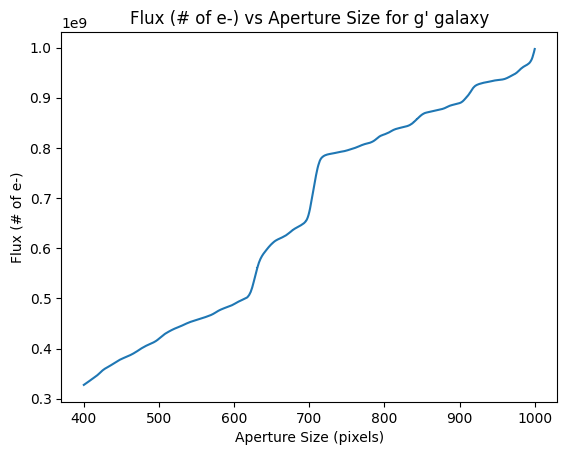

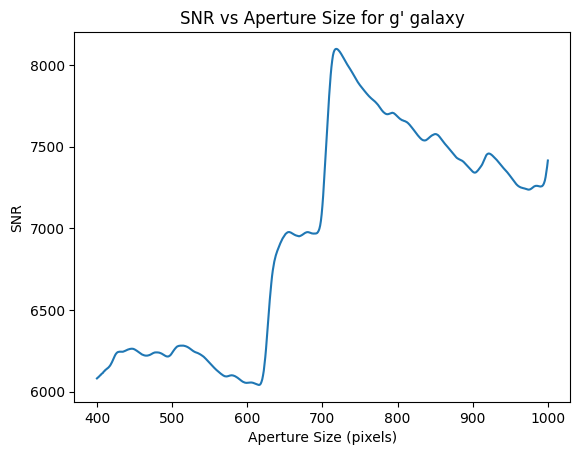

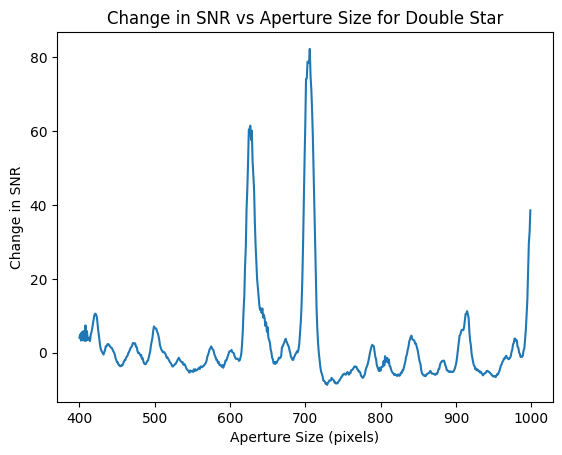

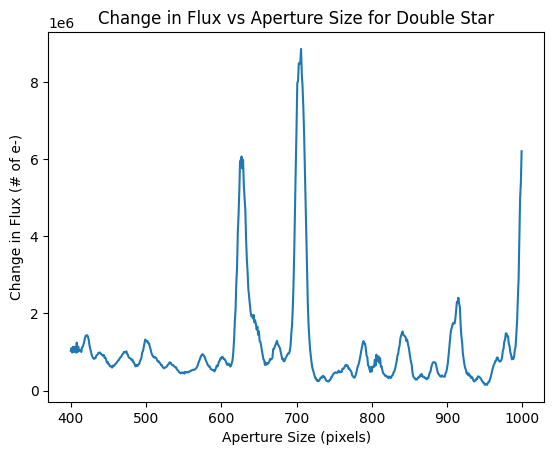

In [74]:
plt.figure()
plt.title('Flux (# of e-) vs Aperture Size for g\' galaxy')
plt.errorbar(apertures_one, flux_list, noise1_list, label='Flux')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('Flux (# of e-)')

# Ends at aperture size ~15 as there's a sig error in the function after due to negative sqrt)
plt.figure()
plt.title('SNR vs Aperture Size for g\' galaxy')
plt.plot(apertures_one, snr1_list, label='SNR')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('SNR')

list_of_changes = []
change_flux = []

for i in range(len(snr1_list)-1):
    change = snr1_list[i+1] - snr1_list[i]
    list_of_changes.append(change)

for i in range(len(flux_list)-1):
    change_f = flux_list[i+1] - flux_list[i]
    change_flux.append(change_f)

plt.figure()
plt.title('Change in SNR vs Aperture Size for Double Star')
plt.plot(apertures_one[:-1], list_of_changes, label='Change in SNR')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('Change in SNR')

plt.figure()
plt.title('Change in Flux vs Aperture Size for Double Star')
plt.plot(apertures_one[:-1], change_flux, label='Change in Flux')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('Change in Flux (# of e-)')


In [52]:
import numpy as np

def max_snr_in_segment(apertures, snr_list, min_ap, max_ap):
    """
    Find the aperture (and index) with maximum SNR inside [min_ap, max_ap].
    apertures : 1D array-like of aperture sizes
    snr_list  : 1D array-like of SNR values (same length)
    min_ap,max_ap : numeric bounds (inclusive)

    Returns: (global_index, aperture_value, snr_value)
    or (None,None,None) if nothing valid.
    """
    apertures = np.asarray(apertures)
    snr_arr = np.asarray(snr_list, dtype=float)

    # mask out invalid entries
    valid = np.isfinite(snr_arr)

    # mask within requested aperture window
    in_window = (apertures >= min_ap) & (apertures <= max_ap)

    mask = valid & in_window
    if not mask.any():
        return None, None, None

    idx_local = np.nanargmax(snr_arr[mask])            # index into filtered array
    # map local index back to global index
    global_indices = np.nonzero(mask)[0]
    global_idx = global_indices[idx_local]

    return int(global_idx), float(apertures[global_idx]), float(snr_arr[global_idx])

In [75]:
# Max SNR in g' between 700 and 800 pixel aperture sizes

index, d, c = max_snr_in_segment(apertures_one, snr1_list, 700, 800)

In [ ]:
# Values for g'

print(snr1_list[index])
print(noise1_list[index])
print(flux_list[index])
print(apertures_one[index])

# Before AperE alteration values for g' were:
8097.748529633308
96643.05776590462
782591178.923121
718.0

8097.748529633308
96643.05776590462
782591178.923121
718.0


718.0

In [88]:
# We can ser inner and outer radii arbitrarily far out, as sky is fairly uniform, and only scales the net flux determined from the star alone
# But relative flux magnetiude should remain same for various aperture sizes


col = 3320      # your estimated source X
row = 2190      # your estimated source Y
rad = 660
n = 300
ir = 1010
or_ = 1040

apertures_one = np.linspace(rad - n, rad + n, 1 + 2*n)

noise2_list = []
flux2_list = []
snr2_list = []
for ap in range(len(apertures_one)):
    flux2, noise2 = aperE_graphless_new(temp_data1, col, row, apertures_one[ap], apertures_one[ap], ir, ir, or_, or_, 1/0.242862924933434) # EGAIN found from header of uncalibrated science images
    noise2_list.append(noise2)
    flux2_list.append(flux2)
    snr2_list.append(flux2/noise2) # SNR is flux divided by noise



Text(0, 0.5, 'Change in Flux (# of e-)')

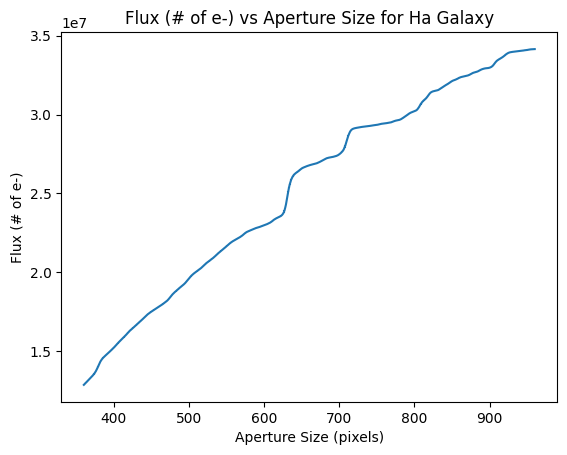

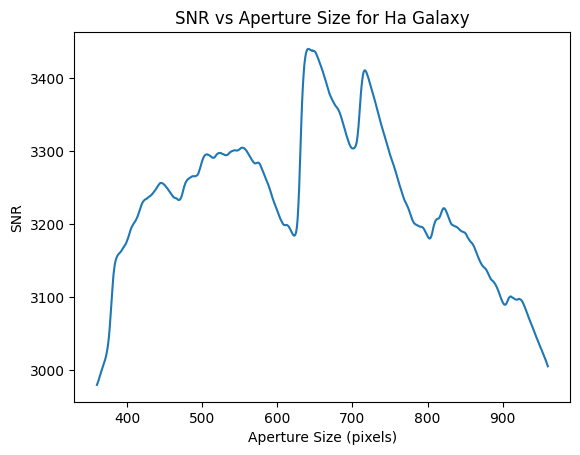

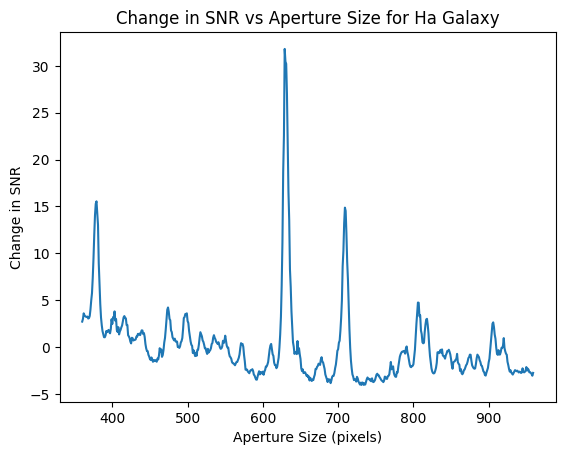

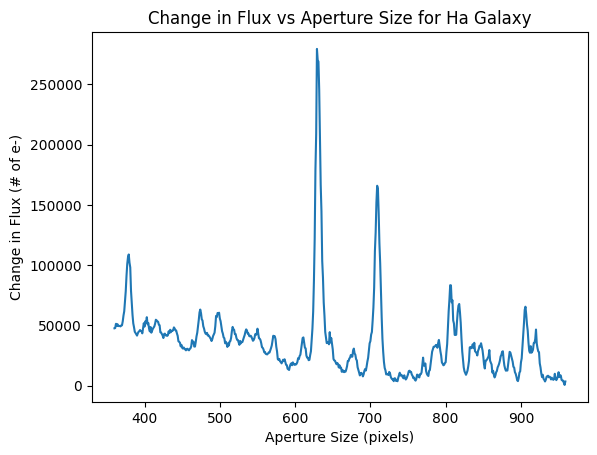

In [89]:
plt.figure()
plt.title('Flux (# of e-) vs Aperture Size for Ha Galaxy')
plt.errorbar(apertures_one, flux2_list, noise2_list, label='Flux')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('Flux (# of e-)')

# Ends at aperture size ~15 as there's a sig error in the function after due to negative sqrt)
plt.figure()
plt.title('SNR vs Aperture Size for Ha Galaxy')
plt.plot(apertures_one, snr2_list, label='SNR')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('SNR')

list_of_changes = []
change_flux = []

for i in range(len(snr2_list)-1):
    change = snr2_list[i+1] - snr2_list[i]
    list_of_changes.append(change)

for i in range(len(flux2_list)-1):
    change_f = flux2_list[i+1] - flux2_list[i]
    change_flux.append(change_f)

plt.figure()
plt.title('Change in SNR vs Aperture Size for Ha Galaxy')
plt.plot(apertures_one[:-1], list_of_changes, label='Change in SNR')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('Change in SNR')

plt.figure()
plt.title('Change in Flux vs Aperture Size for Ha Galaxy')
plt.plot(apertures_one[:-1], change_flux, label='Change in Flux')
plt.xlabel('Aperture Size (pixels)')
plt.ylabel('Change in Flux (# of e-)')



In [90]:
# Peak is between 600 and 800 pixel aperture sizes
index, d, c = max_snr_in_segment(apertures_one, snr2_list, 600, 652)

In [92]:
# Values for Ha

print(snr2_list[index])
print(noise2_list[index])
print(flux2_list[index])
print(apertures_one[index])

# Before AperE alteration values for Ha were (they match!):
3439.670036951215
7641.770915326173
26285170.446692698
642.0

3439.670036951215
7641.770915326173
26285170.446692698
642.0


642.0

In [98]:
# Now we must vary the sky annulus inner and outer radii to see their effect on SNR and flux
# For g' image (gap of 30 pixels between inner and outer radii is fixed for sufficient sky sampling)

aperture = 718
ir_values = np.arange(720, 1011, 1)
or_values = ir_values + 30
col = 3320 
row = 2190

noise1_list = []
flux_list = []
snr1_list = []
for ap in range(len(ir_values)):
    flux, noise1 = aperE_graphless_new(temp_data, col, row, aperture, aperture, ir_values[ap], ir_values[ap], or_values[ap], or_values[ap], 1/0.242862924933434) # EGAIN found from header of uncalibrated science images
    noise1_list.append(noise1)
    flux_list.append(flux)
    snr1_list.append(flux/noise1) # SNR is flux divided by noise


Text(0, 0.5, 'Change in Flux (# of e-)')

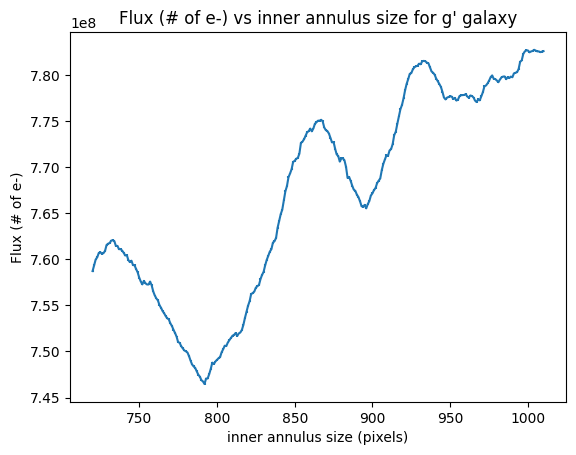

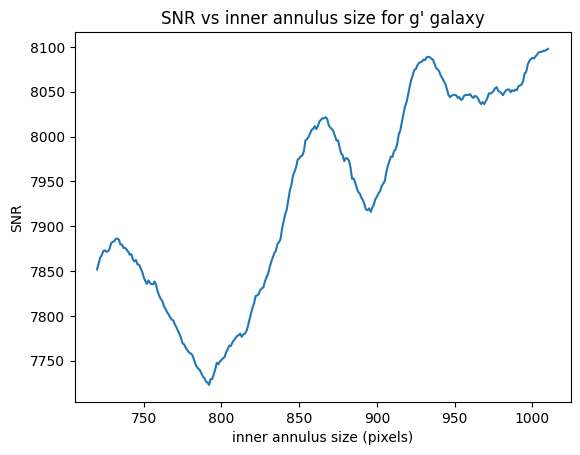

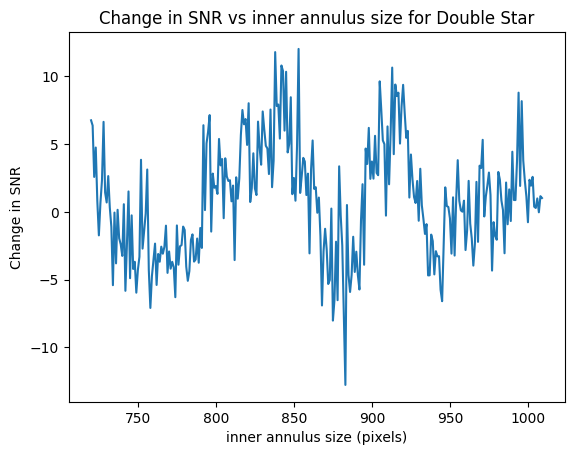

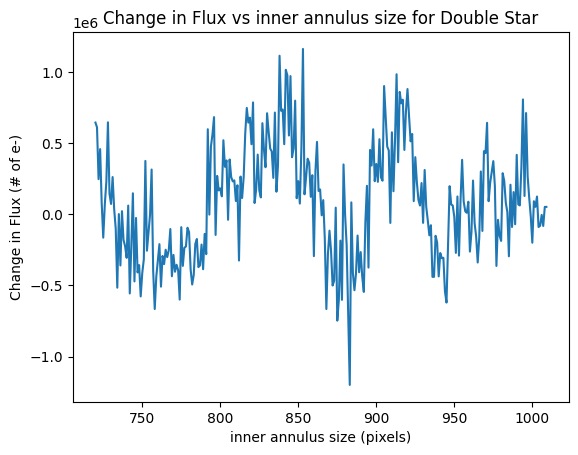

In [ ]:
plt.figure()
plt.title('Flux (# of e-) vs inner annulus size for g\' galaxy')
plt.errorbar(ir_values, flux_list, noise1_list, label='Flux')
plt.xlabel('inner annulus size (pixels)')
plt.ylabel('Flux (# of e-)')

# Ends at aperture size ~15 as there's a sig error in the function after due to negative sqrt)
plt.figure()
plt.title('SNR vs inner annulus size for g\' galaxy')
plt.plot(ir_values, snr1_list, label='SNR')
plt.xlabel('inner annulus size (pixels)')
plt.ylabel('SNR')

list_of_changes = []
change_flux = []

for i in range(len(snr1_list)-1):
    change = snr1_list[i+1] - snr1_list[i]
    list_of_changes.append(change)

for i in range(len(flux_list)-1):
    change_f = flux_list[i+1] - flux_list[i]
    change_flux.append(change_f)

plt.figure()
plt.title('Change in SNR vs inner annulus size for galaxy')
plt.plot(ir_values[:-1], list_of_changes, label='Change in SNR')
plt.xlabel('inner annulus size (pixels)')
plt.ylabel('Change in SNR')

plt.figure()
plt.title('Change in Flux vs inner annulus size for galaxy')
plt.plot(ir_values[:-1], change_flux, label='Change in Flux')
plt.xlabel('inner annulus size (pixels)')
plt.ylabel('Change in Flux (# of e-)')


In [100]:
# Values for g'
index, d, c = max_snr_in_segment(ir_values, snr1_list, 900, 1010)
print(snr1_list[index])
print(noise1_list[index])
print(flux_list[index])
print(ir_values[index])

8097.748529633308
96643.05776590462
782591178.923121
1010


In [ ]:
# Values for g'
index, d, c = max_snr_in_segment(ir_values, snr1_list, 900, 1000)
print(snr1_list[index])
print(noise1_list[index])
print(flux_list[index])
print(ir_values[index])

# Close to Ha as you will see below!

8088.970534430111
96617.97237138775
781539931.608538
933


In [104]:
# We can ser inner and outer radii arbitrarily far out, as sky is fairly uniform, and only scales the net flux determined from the star alone
# But relative flux magnetiude should remain same for various aperture sizes

aperture = 718
ir_values = np.arange(720, 1011, 1)
or_values = ir_values + 30
col = 3320 
row = 2190

noise2_list = []
flux2_list = []
snr2_list = []
for ap in range(len(ir_values)):
    flux2, noise2 = aperE_graphless_new(temp_data1, col, row, aperture, aperture, ir_values[ap], ir_values[ap], or_values[ap], or_values[ap], 1/0.242862924933434) # EGAIN found from header of uncalibrated science images
    noise2_list.append(noise2)
    flux2_list.append(flux2)
    snr2_list.append(flux2/noise2) # SNR is flux divided by noise



Text(0, 0.5, 'Change in Flux (# of e-)')

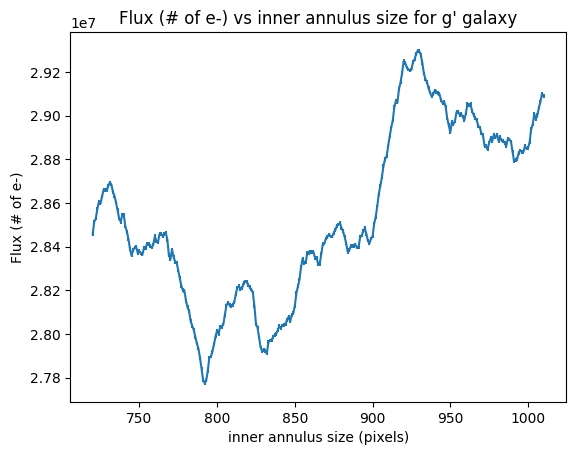

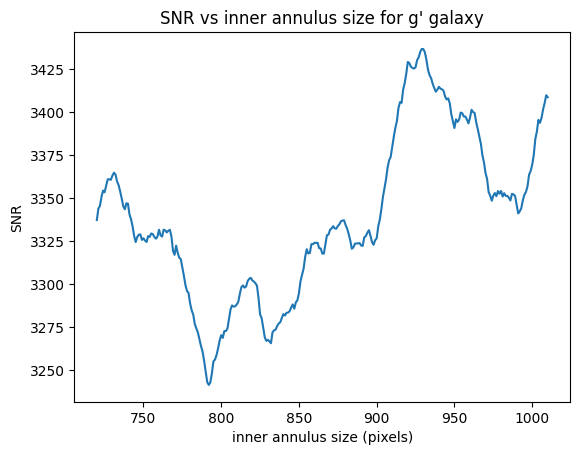

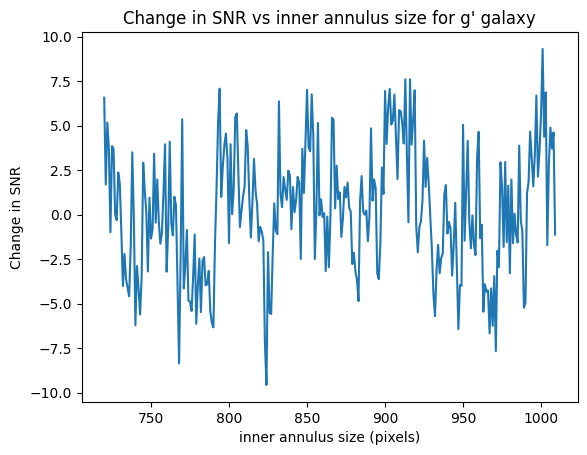

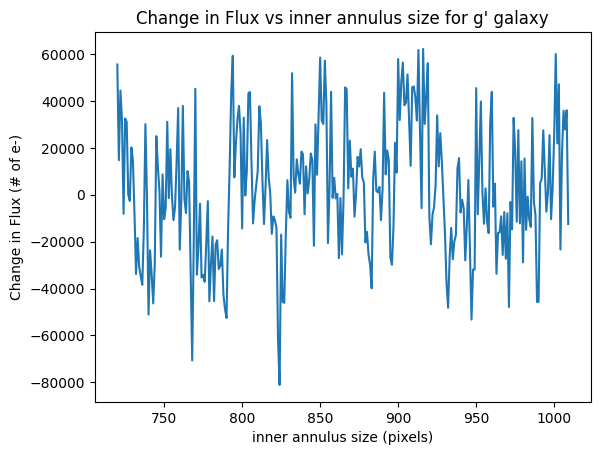

In [105]:
plt.figure()
plt.title('Flux (# of e-) vs inner annulus size for g\' galaxy')
plt.errorbar(ir_values, flux2_list, noise2_list, label='Flux')
plt.xlabel('inner annulus size (pixels)')
plt.ylabel('Flux (# of e-)')

# Ends at aperture size ~15 as there's a sig error in the function after due to negative sqrt)
plt.figure()
plt.title('SNR vs inner annulus size for g\' galaxy')
plt.plot(ir_values, snr2_list, label='SNR')
plt.xlabel('inner annulus size (pixels)')
plt.ylabel('SNR')

list_of_changes = []
change_flux = []

for i in range(len(snr2_list)-1):
    change = snr2_list[i+1] - snr2_list[i]
    list_of_changes.append(change)

for i in range(len(flux2_list)-1):
    change_f = flux2_list[i+1] - flux2_list[i]
    change_flux.append(change_f)

plt.figure()
plt.title('Change in SNR vs inner annulus size for g\' galaxy')
plt.plot(ir_values[:-1], list_of_changes, label='Change in SNR')
plt.xlabel('inner annulus size (pixels)')
plt.ylabel('Change in SNR')

plt.figure()
plt.title('Change in Flux vs inner annulus size for g\' galaxy')
plt.plot(ir_values[:-1], change_flux, label='Change in Flux')
plt.xlabel('inner annulus size (pixels)')
plt.ylabel('Change in Flux (# of e-)')

In [106]:
# Values for Ha
index, d, c = max_snr_in_segment(ir_values, snr2_list, 900, 1010)
print(snr2_list[index])
print(noise2_list[index])
print(flux2_list[index])
print(ir_values[index])

3436.880713411837
8524.52763188088
29297784.608957674
929
